In [72]:
# Use networkx to create a graph with the relations
import networkx as nx
import random
from math import log10
from udpipe2_tuples_generator import run_sequential, break_text_into_sentences, get_all_text_from_folder

import matplotlib.pyplot as plt

def plot_graph(tuples, name, interesting_subjects = []):
    G = nx.Graph()
    number_of_objects_per_subject = [0] * len(interesting_subjects)
    random.shuffle(tuples)
    for tuple in tuples:
        subject = tuple[0]
        relation = tuple[1]
        object_ = tuple[2]
        if subject in interesting_subjects and number_of_objects_per_subject[interesting_subjects.index(subject)] < 5:
            G.add_edge(subject, object_, relation=relation)
            number_of_objects_per_subject[interesting_subjects.index(subject)] += 1

    plt.figure(figsize=(15,15))
    pos = nx.spring_layout(G, k=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='g')
    if len(interesting_subjects) > 0:
        nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n in interesting_subjects], node_size=1000, node_color='r')
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'relation'), font_size=16)

    plt.axis('off')
    plt.savefig(name + '.png', dpi=300)


In [2]:
# Create the final graph with all the nodes and edges
def create_graph(tuples):
    G = nx.Graph()
    for string_tuple in tuples:
        subject = string_tuple[0]
        relation = string_tuple[1]
        object_ = string_tuple[2]
        G.add_edge(subject, object_, relation=relation)
    return G

In [3]:
def get_all_shortest_paths(tuples):
    global G
    all_shortest_paths = []
    for tuple in tuples:
        source = tuple[0]
        relation = tuple[1]
        target = tuple[2]
        try:
            for path in nx.all_shortest_paths(G, source=source, target=target):
                all_shortest_paths.append([path, relation])
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            pass
    return all_shortest_paths

def rate_sentence(sentence):
    string_tuples = run_sequential(sentence)
    all_shortest_paths = get_all_shortest_paths(string_tuples)

    if len(all_shortest_paths) == 0:
        return 0

    def rate_path(path, relation):
        global G
        if len(path) == 2:
            return 1
        
        score = 1 / (1 + sum([log10(G.degree(node)) for node in path[1:-1]]))

        # # add 1 to the score if relation appers in the path
        # if relation in path:
        #     score += 1
        
        return score
    
    return sum([rate_path(path, relation) for [path, relation] in all_shortest_paths])/len(all_shortest_paths)

def rate_text(text):
    sentences = break_text_into_sentences(text)
    return sum([rate_sentence(sentence) for sentence in sentences]) / len(sentences)
        

In [4]:
import threading
from tqdm.notebook import tqdm

def rate_texts_threaded(start, end, master):
    global df
    if master:
        for index, row in tqdm(df.iloc[start:end].iterrows(), total=end-start, unit='rows', mininterval=1, desc='[Master] Rating texts'):
            df.loc[index, 'rating'] = rate_text(df.loc[index, 'content'])
    else:
        for index, row in df.iloc[start:end].iterrows():
            df.loc[index, 'rating'] = rate_text(df.loc[index, 'content'])

def run_with_threads():
    global df
    number_of_threads = 8
    number_of_rows = df.shape[0]
    threads = []
    for i in range(number_of_threads):
        start = int(i * number_of_rows // number_of_threads)
        end = int((i + 1) * number_of_rows // number_of_threads) if i != number_of_threads - 1 else number_of_rows
        threads.append(threading.Thread(target=rate_texts_threaded, args=(start,end, i==number_of_threads-1)))
        threads[-1].start()

    for thread in threads:
        thread.join()

In [5]:
import seaborn as sns
from scipy.stats import norm, chi2
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def test_classification():
    global train, test

    def classify_news(rate):
        nonlocal avg_rating_fake, std_rating_fake, avg_rating_true, std_rating_true, cant_classify_count
        likelihood_fake = norm.pdf(rate, loc=avg_rating_fake, scale=std_rating_fake)
        likelihood_true = norm.pdf(rate, loc=avg_rating_true, scale=std_rating_true)
        rate = likelihood_fake / likelihood_true

        critical_value = chi2.ppf(q=0.95, df=1)
        if rate > critical_value:
            if rate < 1:
                return 1
            else:
                return 0
        else:
            # we can't classify the news, but we do it anyway
            cant_classify_count += 1
            if rate < 1:
                return 1
            else:
                return 0

    avg_rating_fake = train[train['label'] == 0]['rating'].mean()
    std_rating_fake = train[train['label'] == 0]['rating'].std()
    avg_rating_true = train[train['label'] == 1]['rating'].mean()
    std_rating_true = train[train['label'] == 1]['rating'].std()
    print(f'The average rating for fake news is {avg_rating_fake} ({std_rating_fake}) while the average rating for true news is {avg_rating_true} ({std_rating_true})')


    cant_classify_count = 0
    test['predicted_label'] = test['rating'].apply(classify_news)


    print(f'We could not classify with confidence {cant_classify_count} news.')
    print(f'Accuracy: {accuracy_score(test["label"], test["predicted_label"])}')
    print(classification_report(test['label'], test['predicted_label'], zero_division=1))
    
def create_box_plot():
    global train
    box_data = train.copy()
    box_data['label'] = box_data['label'].replace({0: 'Fake news', 1: 'True news'})
    sns.boxplot(x='label', y='rating', data=box_data)
    plt.xlabel('Label')
    plt.ylabel('Truth value')
    plt.savefig('true-fake-boxplot.png', dpi=300)

In [6]:
import pandas as pd

tuples_g1 = pd.read_csv('../data/csvs/g1_tuples_udpipe.csv').values.tolist()
tuples_fakebr = pd.read_csv('../data/csvs/fake_br_corpus_tuples_udpipe.csv').values.tolist()

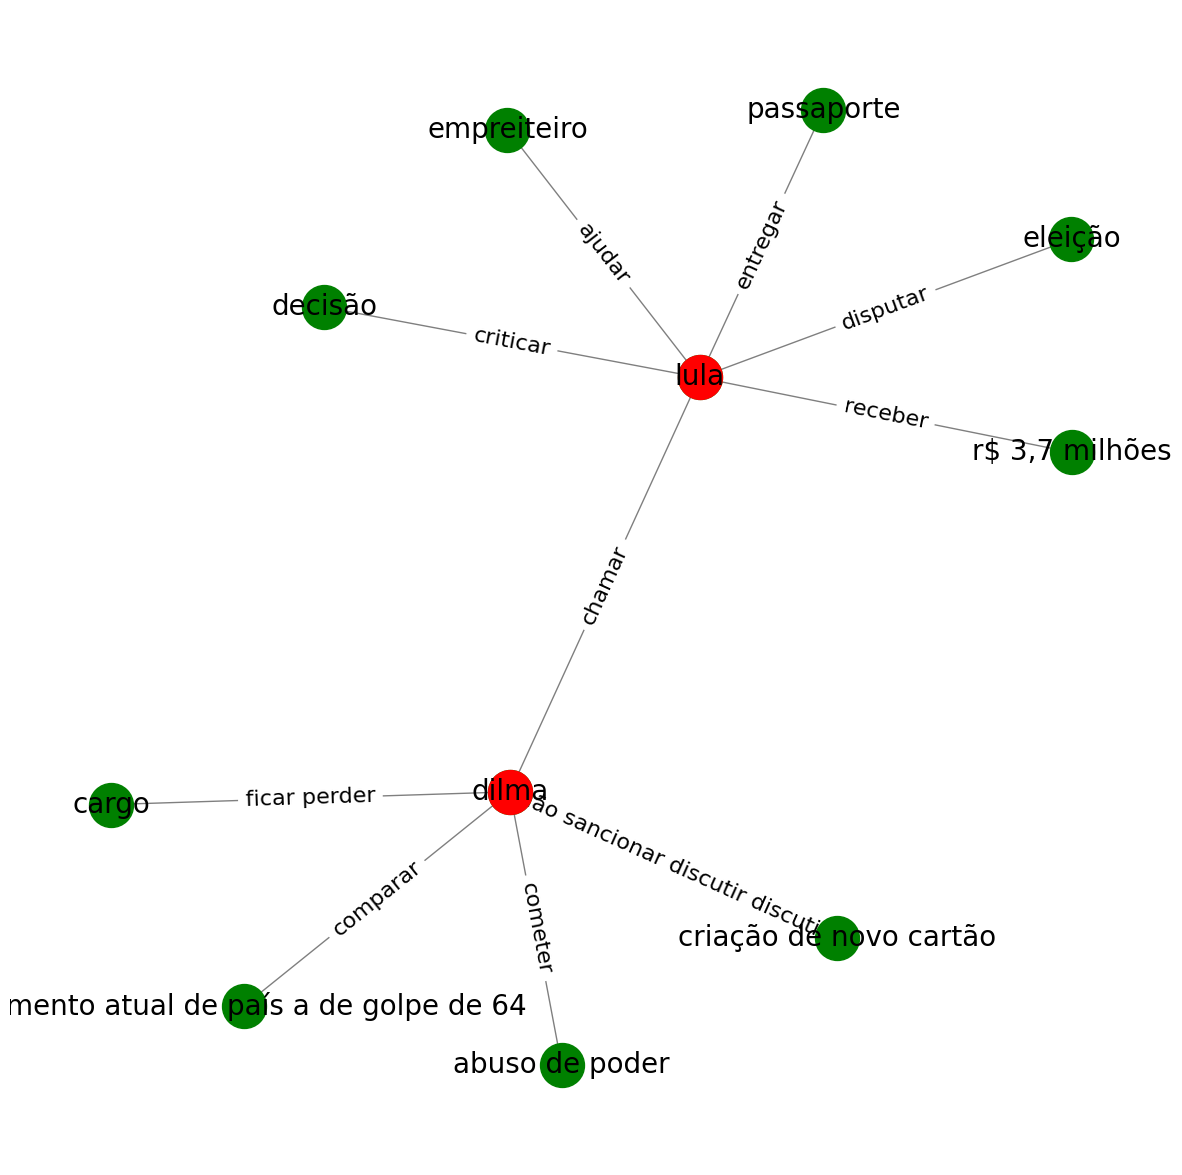

In [76]:
interesting_subjects = ['lula', 'dilma']
plot_graph(tuples_fakebr, 'g1_graph_lula_bolsonaro', interesting_subjects)

In [7]:
fake_texts_df = get_all_text_from_folder('../data/text_files/full_texts/fake')
true_texts_df = get_all_text_from_folder('../data/text_files/full_texts/true')
fake_texts_df['label'] = 0
true_texts_df['label'] = 1
test_df = pd.concat([fake_texts_df, true_texts_df])

# shuffle the dataframe
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df.head()


,content,label
0,chorando as pitangas: bonner posta frase de do...,0
1,"na bahia, adolescente de 14 anos prevê a própr...",0
2,"segunda-feira, 12 de março. bom dia! aqui estã...",1
3,"a insanidade de lula: se me prenderem, eu viro...",0
4,criança apanha de mulher petista só porque usa...,0


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(test_df['content'], test_df['label'], shuffle=True, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.head()

,content,label
2034,﻿juiz determina soltura de 4 presos por pensão...,1
3250,"pivô do mensalão, jefferson não assistiu à tra...",1
3366,oficial da reserva avisa: se a lei do impeachm...,0
1423,bolsonaro vai para o psl e liberais abandonam ...,1
122,"por maioria de votos, os ministros da 2.a tur...",1


In [19]:
df = train.copy()
G = create_graph(tuples_fakebr)
run_with_threads()
train = df.copy()

[Master] Rating texts:   0%|          | 0/240 [00:00<?, ?rows/s]

In [11]:
df = test.copy()
G = create_graph(tuples_fakebr)
run_with_threads()
test = df.copy()

[Master] Rating texts:   0%|          | 0/60 [00:00<?, ?rows/s]

In [23]:
print(f'Train has {train.shape[0]} rows, with {train["rating"].isna().sum()} NaN values. Test has {test.shape[0]} rows, with {test["rating"].isna().sum()} NaN values.')
train.dropna(inplace=True)
test.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Train has 5760 rows, with 0 NaN values. Test has 1440 rows, with 0 NaN values.


The average rating for fake news is 0.020605180574336926 (0.04652447177210151) while the average rating for true news is 0.04006992211915242 (0.05481750287947271)
We could not classify with confidence 1440 news.
Accuracy: 0.5805555555555556
              precision    recall  f1-score   support

           0       0.55      0.87      0.67       723
           1       0.69      0.29      0.41       717

    accuracy                           0.58      1440
   macro avg       0.62      0.58      0.54      1440
weighted avg       0.62      0.58      0.54      1440



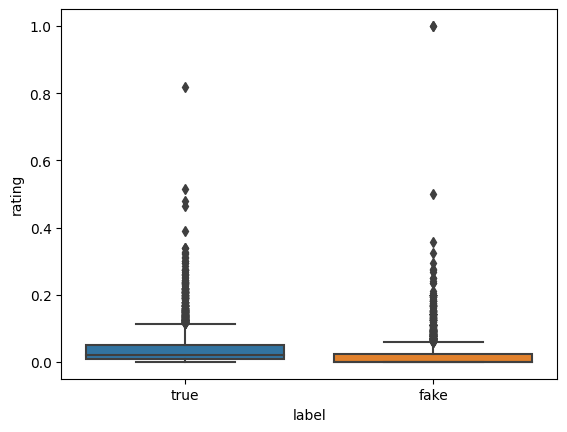

In [270]:
test_classification()
create_box_plot()

### Fakes outliers (107/2880 amostras com mais de 2 desvios padrao fora da média)
=> Noticias verdadeiras e, as vezes, opiniões dos autores

1145 (1.0), 1243 (1.0) 1206 (0.5), 322 (0.35), 2948 (0.33)

### Trues com nota 0 (310/2880 amostras)
=> Em geral, notícias bastante diferentes entre si. Provavelmente seja falta de informação no grafo de conhecimento

3382, 2619, 2656, 183, 703


In [20]:
# save to csv train and test
train.to_csv('../data/csvs/train.csv', index=False)
test.to_csv('../data/csvs/test.csv', index=False)

In [64]:
# Checkpoint
train = pd.read_csv('../data/csvs/train.csv')
test = pd.read_csv('../data/csvs/test.csv')

After dropping the outliers, the train dataset has 5760 rows (2877 fakes and 2883 true). It had 5760 rows before.
The average rating for fake news is 0.020605180574336926 (0.04652447177210151) while the average rating for true news is 0.04006992211915242 (0.05481750287947271)
We could not classify with confidence 1440 news.
Accuracy: 0.5805555555555556
              precision    recall  f1-score   support

           0       0.55      0.87      0.67       723
           1       0.69      0.29      0.41       717

    accuracy                           0.58      1440
   macro avg       0.62      0.58      0.54      1440
weighted avg       0.62      0.58      0.54      1440



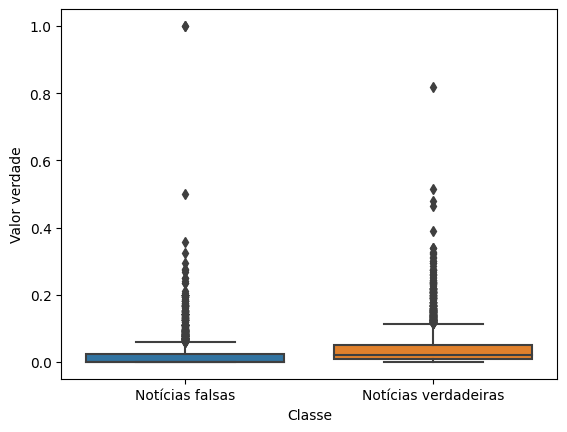

In [65]:
# Remove outliers from the train dataset using the z-score
import numpy as np
from scipy import stats

train_fake_no_outliers = train[train['label'] == 0]
train_true_no_outliers = train[train['label'] == 1]
train_no_outliers = pd.concat([train_fake_no_outliers, train_true_no_outliers])
train_no_outliers.reset_index(drop=True, inplace=True)
print(f'After dropping the outliers, the train dataset has {train_no_outliers.shape[0]} rows ({train_no_outliers[train_no_outliers["label"] == 0].shape[0]} fakes and {train_no_outliers[train_no_outliers["label"] == 1].shape[0]} true). It had {train.shape[0]} rows before.')
train = train_no_outliers.copy()

test_classification()
create_box_plot()

In [43]:
# print the number of news with rating 0 per label
print(f'Number of news with rating 0 per label: {train[train["rating"] == 0].groupby("label").count()["rating"]}')
print(f'Number of news with rating 0 per label: {test[test["rating"] == 0].groupby("label").count()["rating"]}')

Number of news with rating 0 per label: label
0    1597
1     309
Name: rating, dtype: int64
Number of news with rating 0 per label: label
0    391
1     78
Name: rating, dtype: int64


# Validação

In [66]:
train = pd.concat([train, test])
train.reset_index(drop=True, inplace=True)
train.drop(columns=['predicted_label'], inplace=True)

covid_fake_df = get_all_text_from_folder('../data/text_files/covid_dataset/fake')
covid_true_df = get_all_text_from_folder('../data/text_files/covid_dataset/true')
covid_fake_df['label'] = 0
covid_true_df['label'] = 1
validation_df = pd.concat([covid_fake_df, covid_true_df]).reset_index(drop=True)

In [67]:
df = validation_df.copy()
G = create_graph(tuples_fakebr)
run_with_threads()
test = df.copy()
test.head(30)


[Master] Rating texts:   0%|          | 0/4 [00:00<?, ?rows/s]

,content,label,rating
0,olá eu sou médico sanitarista e a minha especi...,0,0.000000
1,"isso aí, galera do bem. já no hospital aqui, s...",0,0.000000
2,eslovênia escandalizada - ontem estourou um gr...,0,0.034984
3,presidente da oms não recomenda carnaval em 20...,0,0.000000
4,uma comparação de relatórios oficiais do gover...,0,0.000000
5,bolsas de sangue de não vacinado versus sangue...,0,0.000000
6,os testes pcr de covid-19 são estudos da unive...,0,0.000000
7,diretor geral da oms tedros adhanom diz que nã...,0,0.000000
8,"tedros adhanom ghebreyesus, o atual diretor da...",0,0.000000
9,"oi, pessoal. bom dia. meu nome é mônica travas...",0,0.000000


In [68]:
test_classification()

The average rating for fake news is 0.020833950500581924 (0.04600620353758683) while the average rating for true news is 0.04059537527636132 (0.0549874852319147)
We could not classify with confidence 30 news.
Accuracy: 0.5
              precision    recall  f1-score   support

           0       0.50      0.93      0.65        15
           1       0.50      0.07      0.12        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.38        30
weighted avg       0.50      0.50      0.38        30



In [47]:
df = validation_df.copy()
G = create_graph(tuples_fakebr + tuples_g1)
run_with_threads()
test = df.copy()
test.head(30)


[Master] Rating texts:   0%|          | 0/4 [00:00<?, ?rows/s]

,content,label,rating
0,olá eu sou médico sanitarista e a minha especi...,0,0.000000
1,"isso aí, galera do bem. já no hospital aqui, s...",0,0.000000
2,eslovênia escandalizada - ontem estourou um gr...,0,0.000000
3,presidente da oms não recomenda carnaval em 20...,0,0.000000
4,uma comparação de relatórios oficiais do gover...,0,0.000000
5,bolsas de sangue de não vacinado versus sangue...,0,0.000000
6,os testes pcr de covid-19 são estudos da unive...,0,0.000000
7,diretor geral da oms tedros adhanom diz que nã...,0,0.000000
8,"tedros adhanom ghebreyesus, o atual diretor da...",0,0.000000
9,"oi, pessoal. bom dia. meu nome é mônica travas...",0,0.000000


In [49]:
test_classification()

The average rating for fake news is 0.02053288537772038 (0.04644918740966048) while the average rating for true news is 0.04010902574064907 (0.055276474724471114)
We could not classify with confidence 30 news.
Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

           0       0.52      0.93      0.67        15
           1       0.67      0.13      0.22        15

    accuracy                           0.53        30
   macro avg       0.59      0.53      0.44        30
weighted avg       0.59      0.53      0.44        30

